# EDA — Length of Stay (LOS)

This notebook is a quick exploratory pass on the prepared cohort dataset (`cohort.csv`).

Focus:
- how LOS is distributed (and how heavy the tail is)
- how LOS relates to a few core “complexity” proxies (age, diagnoses, early drug burden, services)
- simple LOS grouping for the later classification setup


In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv(r"..\data\processed\cohort.csv")


## 1. LOS distribution (target)

Start with basic summary statistics for `los_days` to understand scale, skew, and typical ranges.


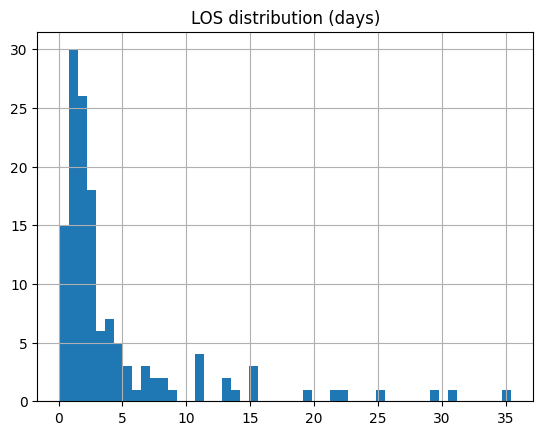

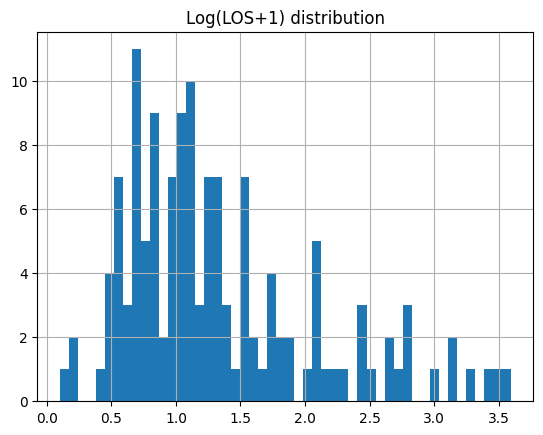

In [62]:
df["los_days"].describe()
df["los_days"].hist(bins=50)
plt.title("LOS distribution (days)")
plt.show()

np.log1p(df["los_days"]).hist(bins=50)
plt.title("Log(LOS+1) distribution")
plt.show()


## 2. Tail check (quantiles)

LOS is usually right-skewed. Quantiles help us see how extreme the tail is without being dominated by max outliers.


In [63]:
df["los_days"].quantile([0.5, 0.9, 0.95, 0.99])


0.50     2.111447
0.90    10.966962
0.95    16.416751
0.99    30.471308
Name: los_days, dtype: float64

## 3. Quick relationships

Sanity-check a few “patient complexity” proxies against LOS:
- age
- number of diagnoses
- number of unique drugs in first 48h
- number of services involved (summarised via group medians)


Age vs LOS:

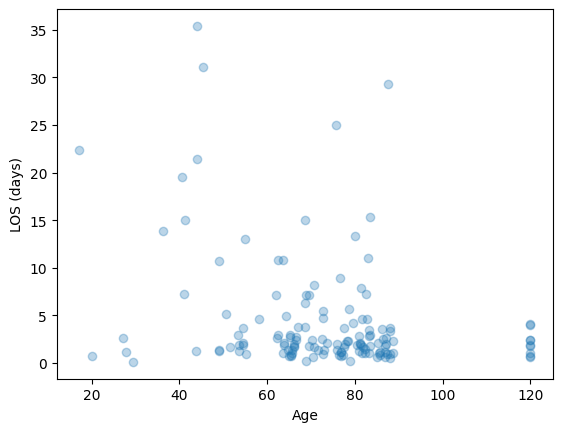

In [64]:
plt.scatter(df["age"], df["los_days"], alpha=0.3)
plt.xlabel("Age")
plt.ylabel("LOS (days)")
plt.show()


Diagnoses vs LOS:

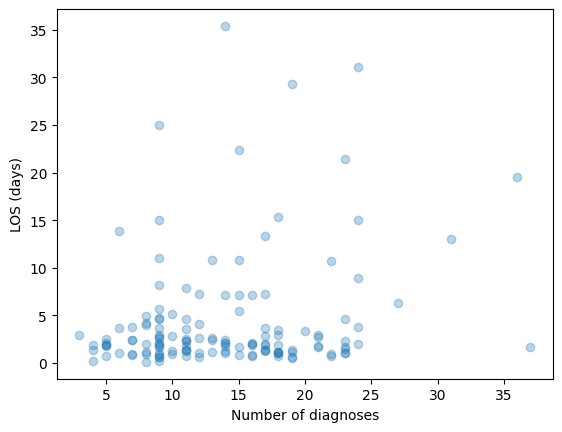

In [65]:
plt.scatter(df["n_diagnoses"], df["los_days"], alpha=0.3)
plt.xlabel("Number of diagnoses")
plt.ylabel("LOS (days)")
plt.show()


Drugs vs LOS:

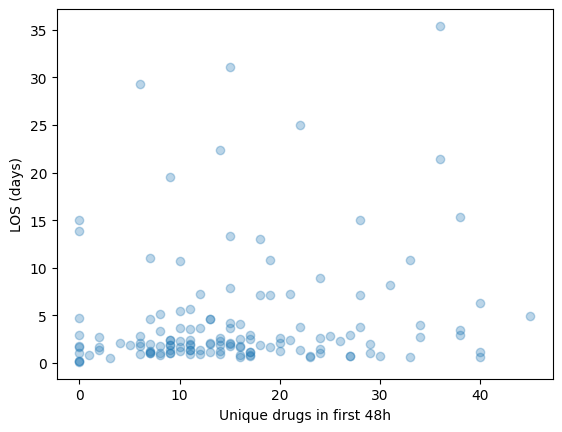

In [66]:
plt.scatter(df["n_unique_drugs_48h"], df["los_days"], alpha=0.3)
plt.xlabel("Unique drugs in first 48h")
plt.ylabel("LOS (days)")
plt.show()


Services vs LOS:

In [67]:
df.groupby("n_services")["los_days"].median()


n_services
1    2.048542
2    2.201192
Name: los_days, dtype: float64

## 4. Categorical breakdowns

Median LOS by key categorical variables (e.g., care unit, admission type) to check for obvious group-level differences.


In [68]:
df.groupby("first_careunit")["los_days"].median().sort_values()
df.groupby("admission_type")["los_days"].median().sort_values()


admission_type
ELECTIVE     1.829300
EMERGENCY    2.111447
URGENT       5.209531
Name: los_days, dtype: float64

In [69]:
df[["first_careunit", "admission_type"]].value_counts()


first_careunit  admission_type
MICU            EMERGENCY         74
SICU            EMERGENCY         20
CCU             EMERGENCY         18
TSICU           EMERGENCY         11
SICU            ELECTIVE           3
CSRU            ELECTIVE           3
                EMERGENCY          3
MICU            ELECTIVE           2
CCU             URGENT             1
MICU            URGENT             1
Name: count, dtype: int64

## 5. LOS grouping for classification

For the classification setup, we create:
- a simple binary flag (`long_stay`) using an empirical threshold
- a multiclass grouping (`los_group`) using day-based bins

These are not “clinical definitions” — they’re practical groupings for modeling and evaluation.


In [70]:
df["long_stay"] = df["los_days"] > df["los_days"].quantile(0.75)
df.groupby("long_stay")[["n_diagnoses","n_unique_drugs_48h","n_services"]].mean()


,n_diagnoses,n_unique_drugs_48h,n_services
long_stay,,,
False,13.274510,14.637255,1.205882
True,15.970588,18.264706,1.205882


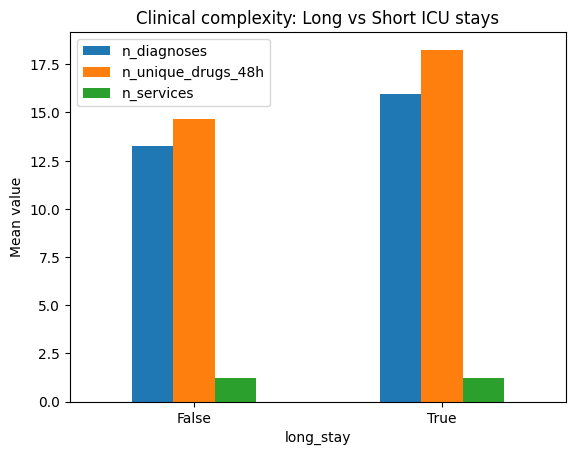

In [71]:
df["long_stay"] = df["los_days"] > df["los_days"].quantile(0.75)

grouped = df.groupby("long_stay")[["n_diagnoses", "n_unique_drugs_48h", "n_services"]].mean()

grouped.plot(kind="bar")
plt.title("Clinical complexity: Long vs Short ICU stays")
plt.ylabel("Mean value")
plt.xticks(rotation=0)
plt.show()


In [72]:
bins = [0, 1, 3, 6, 8, 15, 31, float("inf")]
labels = ["<1d", "1–2d", "3–5d", "6–7d", "7–14d", "14–30d", "30+d"]

df["los_group"] = pd.cut(df["los_days"], bins=bins, labels=labels, right=False)


In [73]:
df["los_group"].value_counts().sort_index()


los_group
<1d       22
1–2d      69
3–5d      19
6–7d       7
7–14d      9
14–30d     8
30+d       2
Name: count, dtype: int64

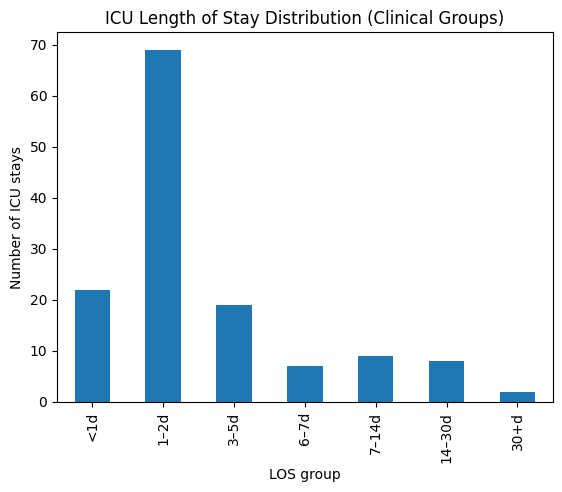

In [74]:
df["los_group"].value_counts().sort_index().plot(kind="bar")
plt.title("ICU Length of Stay Distribution (Clinical Groups)")
plt.ylabel("Number of ICU stays")
plt.xlabel("LOS group")
plt.show()


C:\Users\zhmar\AppData\Local\Temp\ipykernel_43628\941460499.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby("los_group")[["n_diagnoses", "n_services"]].mean()


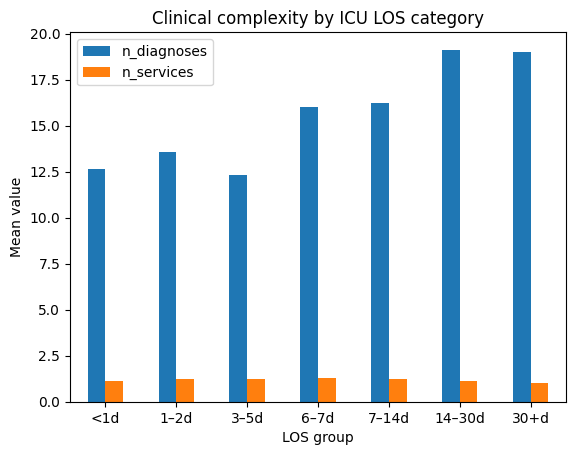

In [75]:
grouped = df.groupby("los_group")[["n_diagnoses", "n_services"]].mean()

grouped.plot(kind="bar")
plt.title("Clinical complexity by ICU LOS category")
plt.ylabel("Mean value")
plt.xlabel("LOS group")
plt.xticks(rotation=0)
plt.show()

## Notes from EDA

At this point we mainly care about:
- how heavy the LOS tail is (important for regression)
- whether the engineered “burden” features move in the expected direction with LOS
- whether LOS groups are reasonably balanced for classification

Next: modeling notebook (regression + multiclass classification + explainability).
